In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm 

In [2]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [3]:
data_folder = '/home/ubuntu/storage/Doc2Answer/download_from_drive/data/ProcessedO7/'

In [4]:
img_fnms = sorted([fn for fn in os.listdir(data_folder) if fn.endswith('.jpg')])
len(img_fnms)

361

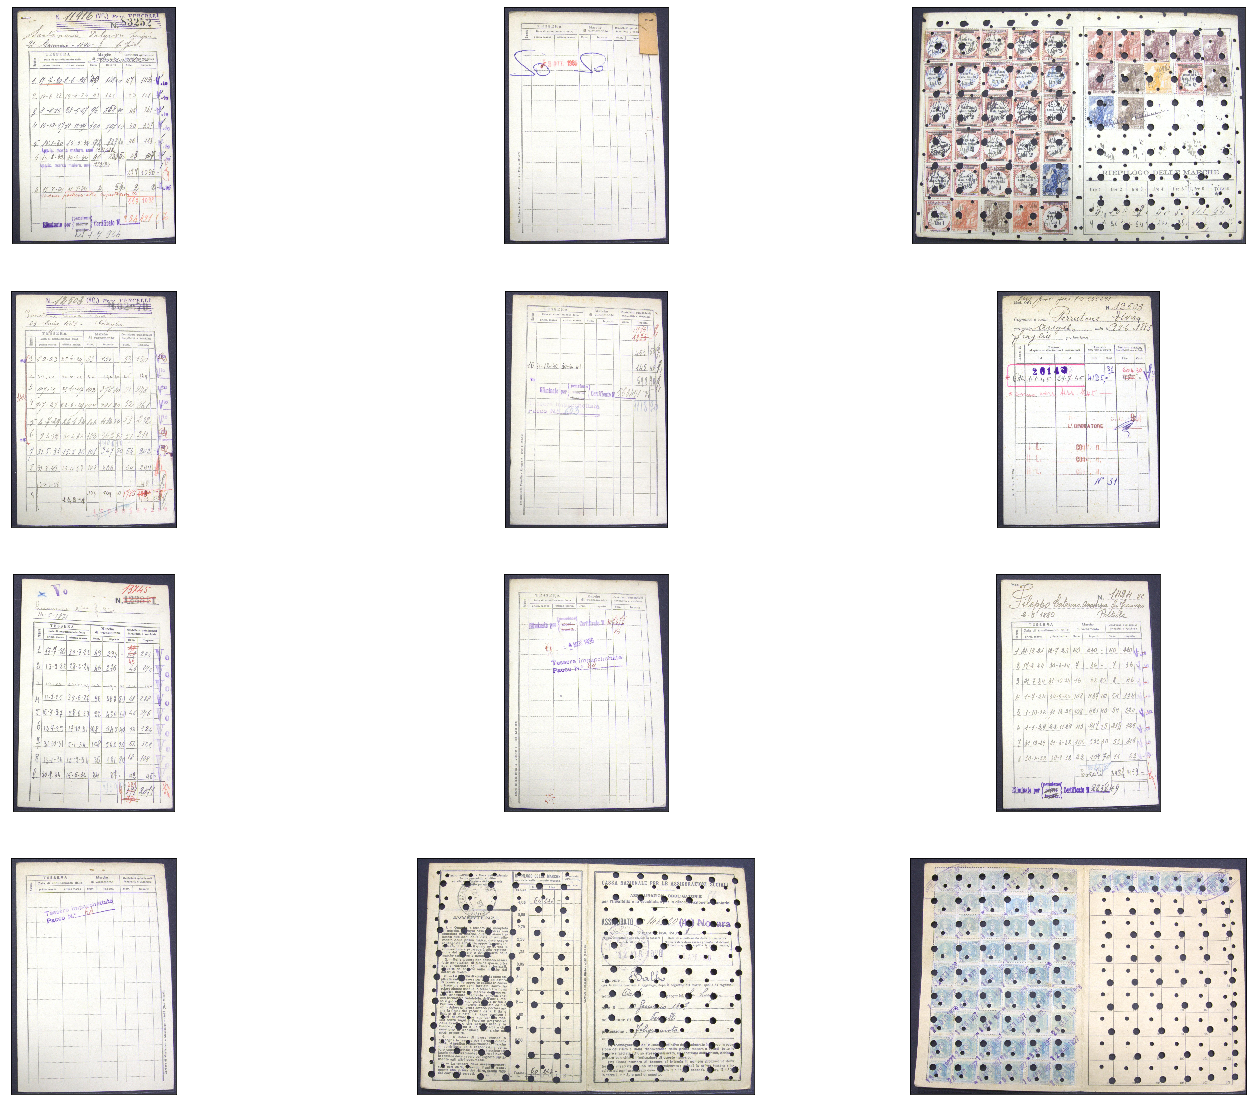

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(25, 20))
for fn, ax in zip(img_fnms[12:24], axes.ravel()):
    path = os.path.join(data_folder, fn)
    ax.imshow(plt.imread(path))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

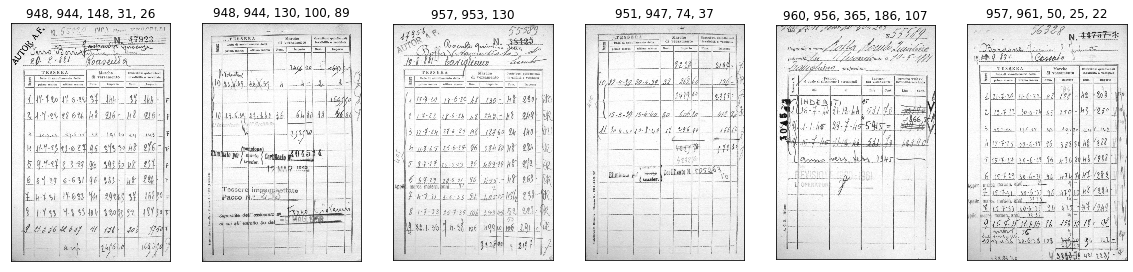

In [24]:
import imutils
from skimage.filters import threshold_local

fig, axes = plt.subplots(1, 6, figsize=(20, 100))
for fn, ax in zip(img_fnms[152:160], axes.ravel()):
    path = os.path.join(data_folder, fn)
    img = cv2.imread(path)
    orig = img.copy()
    ratio = img.shape[0] / 300.0
    img = imutils.resize(img, height = 300)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = cv2.Canny(gray, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = lambda x: cv2.arcLength(x, True), reverse = True)[:5]
    # loop over the contours
    
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            ax.set_title(', '.join([str(int(cv2.arcLength(cv2.approxPolyDP(c, 0.02 * cv2.arcLength(c, True), True), True))) for c in cnts]))
            cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 2)
            warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
            # convert the warped image to grayscale, then threshold it
            # to give it that 'black and white' paper effect
            warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        #     T = threshold_local(warped, 11, offset = 10, method = "gaussian")
        #     warped = (warped > T).astype("uint8") * 255
            ax.imshow(warped, 'gray')
            ax.set_xticks([])
            ax.set_yticks([])
            
            break
    screenCnt = None
plt.show()

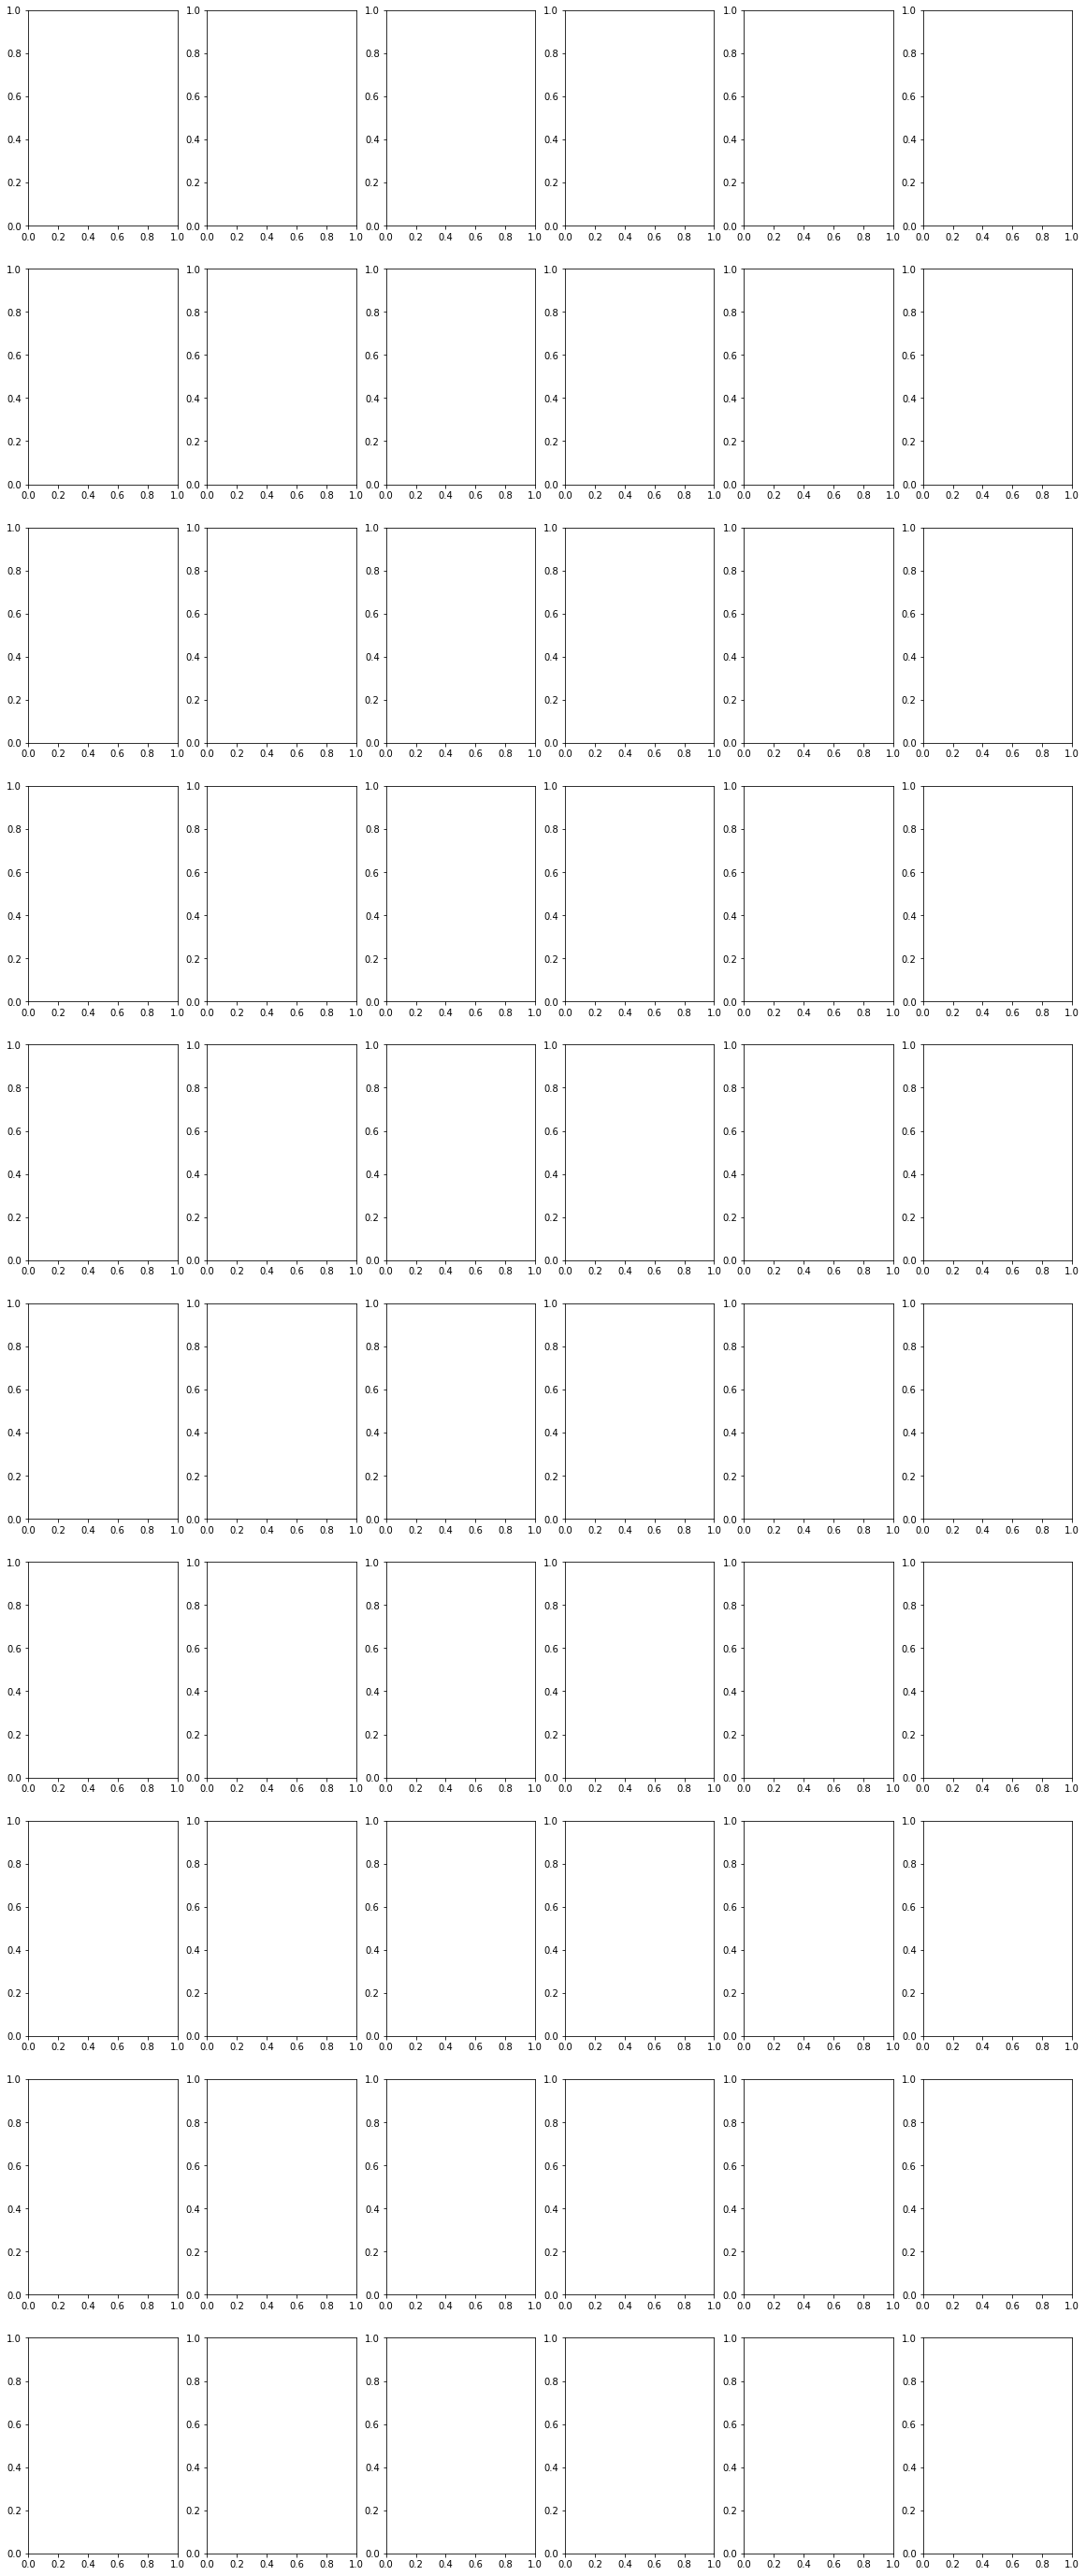

In [25]:
import imutils
from skimage.filters import threshold_local
from scan import DocScanner

scanner = DocScanner()
fig, axes = plt.subplots(10, 6, figsize=(20, 50))
for fn, ax in zip(img_fnms[100:160], axes.ravel()):
    path = os.path.join(data_folder, fn)
    img = cv2.imread(path)
#     img = imutils.resize(img, height=1000)[500:]
    res = scanner.scan(img)
    break

    ax.imshow(res, 'gray')
plt.show()

In [37]:
path = os.path.join(data_folder, fn)
img = cv2.imread(path)
img.shape

(1950, 1300, 3)

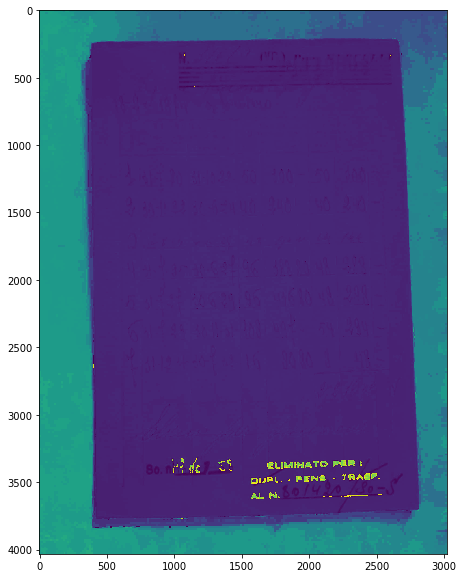

In [24]:
path = os.path.join(data_folder, img_fnms[10])
plt.figure(figsize=(20,10))
image = cv2.imread(path)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv = cv2.split(hsv)
gray = hsv[0]

gray = cv2.GaussianBlur(gray, (1,1), sigmaX=-1, sigmaY=-1)

ret,binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(gray, contours, -1, (0,0,255), 2)
plt.imshow(gray)

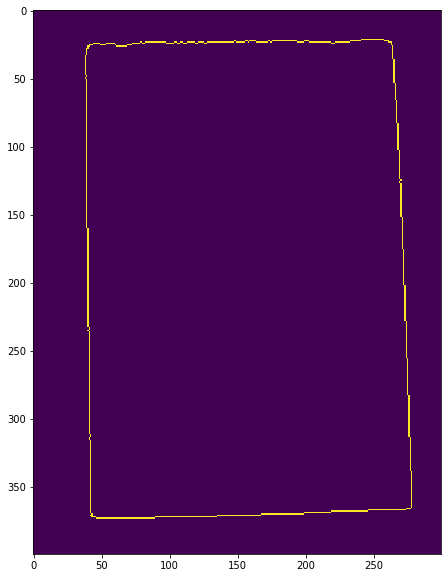

In [163]:
import imutils

path = os.path.join(data_folder, img_fnms[10])
plt.figure(figsize=(20,10))
img = cv2.imread(path)
img = imutils.resize(img, height = 400)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
edged = cv2.Canny(gray, 100, 200)
# img = cv2.blur(img, (3, 3))
# img = img.astype(np.float32)/255.

# kernel = np.array([[0,  -1,  0],
#                    [-1, 4,  -1],
#                    [0, -1,  0]]).astype(np.float32)

# dst = cv2.filter2D(img, -1, kernel)
# dst = ((dst - dst.min()) / (dst.max() - dst.min())*255).astype(np.uint8)

plt.imshow(edged); plt.show()

8 672.5
5 24.0


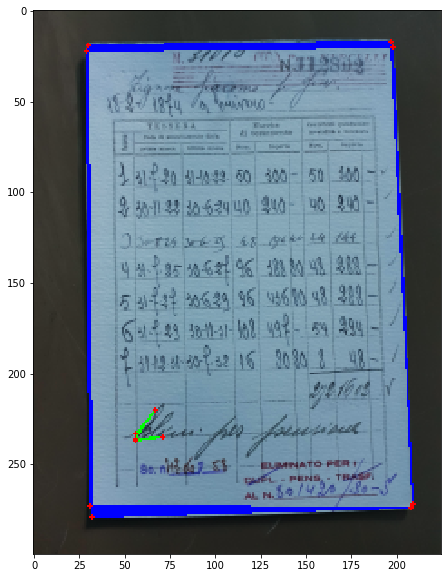

In [219]:
import imutils

path = os.path.join(data_folder, img_fnms[10])
plt.figure(figsize=(20,10))
img = cv2.imread(path)

orig = img.copy()
ratio = img.shape[0] / 300.0
img = imutils.resize(img, height = 300)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
edged = cv2.Canny(gray, 75, 200)
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = lambda x: cv2.arcLength(x, True), reverse = True)[:5]
# loop over the contours
colours = [(0,0,255), (0,255,0), (255,0,0),(255, 0,0)]
for i, c in enumerate(cnts):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(img, [approx], -1, colours[i], -1)
    area = cv2.contourArea(approx)
    for p in approx:
        cv2.drawContours(img, [p], -1, colours[-1], 2)
    print(len(approx), cv2.contourArea(approx))
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4 and area > 200:
        screenCnt = approx
        # ax.set_title(', '.join([str(int(cv2.arcLength(cv2.approxPolyDP(c, 0.02 * cv2.arcLength(c, True), True), True))) for c in cnts]))
        cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 2)
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        # convert the warped image to grayscale, then threshold it
        # to give it that 'black and white' paper effect
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        break
plt.imshow(img)

In [3]:
from scan import DocScanner

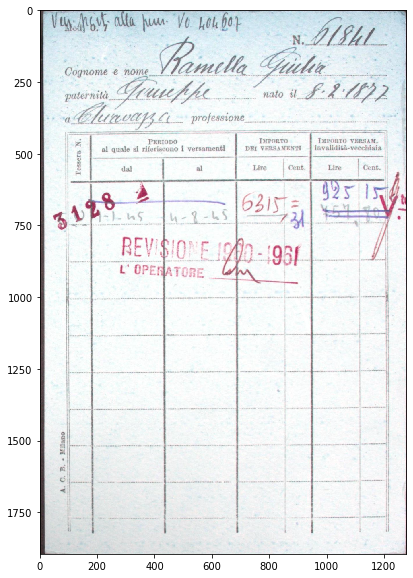

In [26]:
import docdetect
import cv2
import os
import matplotlib.pyplot as plt
import imutils

data_folder = '/home/ubuntu/storage/Doc2Answer/download_from_drive/data/ProcessedO7/'
img_fnms = [fn for fn in os.listdir(data_folder) if fn.endswith('.jpg')]

path = os.path.join(data_folder, img_fnms[100])
plt.figure(figsize=(20,10))
img = cv2.imread(path)
orig = img.copy()
# img = imutils.resize(img, height=500)

scanner = DocScanner()
res = scanner.scan(img)
plt.imshow(res)

In [21]:
rects

[]

In [192]:
mask1.ravel().sum()//1000, mask2.ravel().sum()//1000, mask3.ravel().sum()//1000

(112, 629, 739)

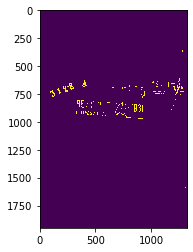

In [50]:
img = cv2.imread(path)
plt.imshow(abs(np.diff(img.astype(np.float32), axis=2)).max(axis=2)>50)

In [175]:
path

'/home/ubuntu/storage/Doc2Answer/download_from_drive/data/ProcessedO7/72263_O7_0704.jpg'

142


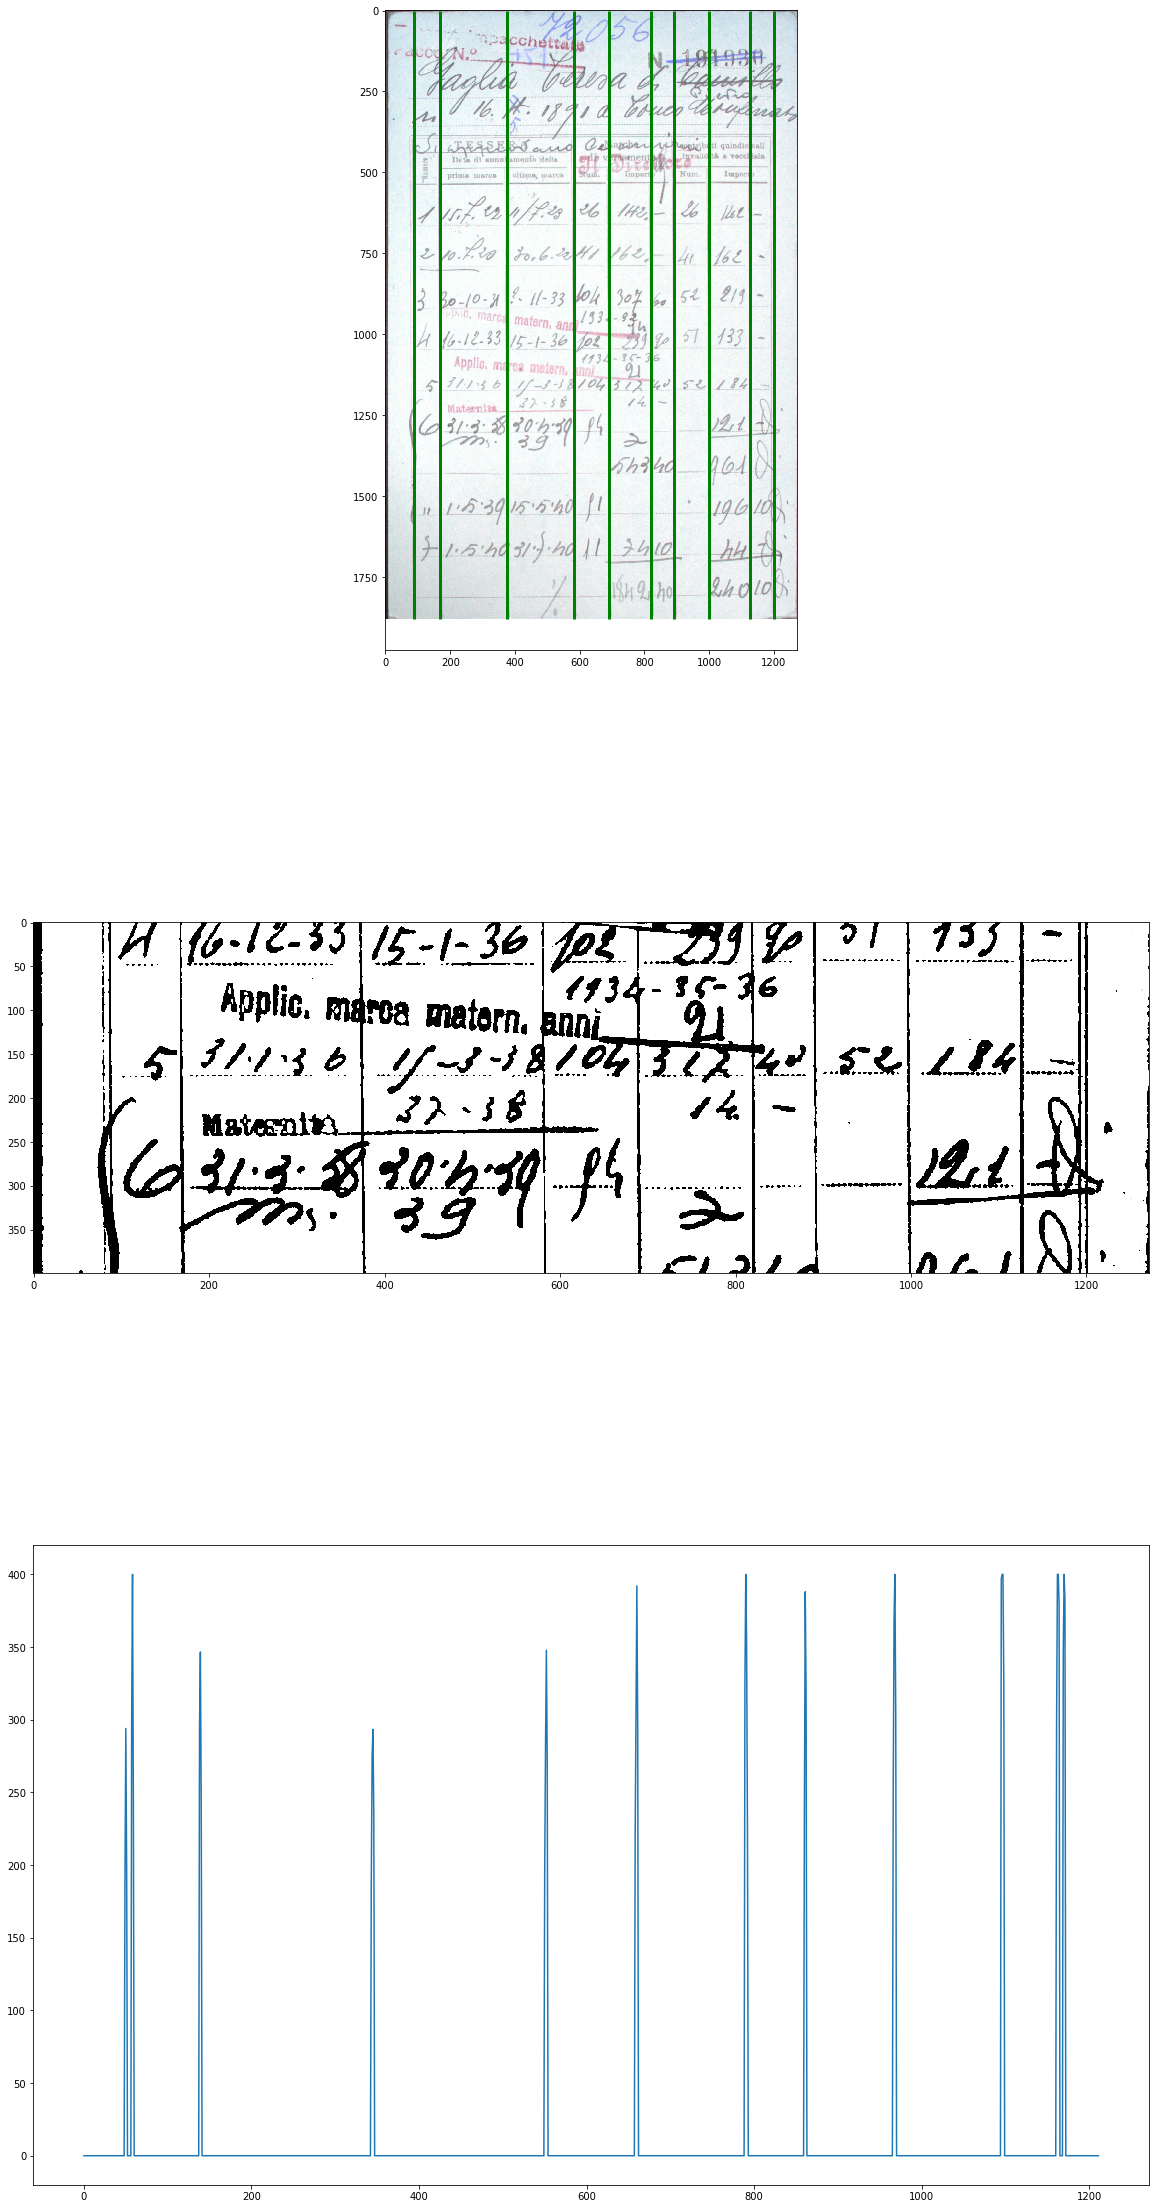

In [176]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
axes = [axes]
n = np.random.randint(100, 160)
print(n)
for fn, ax in zip(img_fnms[n:n+1], axes):
    path = os.path.join(data_folder, fn)
    img = cv2.imread(path)
    scanner = DocScanner()
    img = scanner.scan(img)
    oimg = img.copy()
    img = oimg[1000:1400].copy()
#     mask1 = img.sum(axis=2) < 650
#     mask2 = np.abs(img[:,:,0] - img[:,:,1]) < 20
#     mask3 = np.abs(img[:,:,0] - img[:,:,2]) < 20
#     mask = mask1 * mask2 * mask3
#     img[mask] = 0
#     img[~mask] = 255
    img[abs(np.diff(img.astype(np.float32), axis=2)).max(axis=2)>50] = 255
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray[gray<230] = 0
    gray[gray>230] = 255
#     gray = cv2.blur(gray, (1, 99))
    ax[0].imshow(oimg)
    ax[1].imshow(gray, 'gray')
    spectrum = gray.sum(axis=0)[30:-30].astype(np.float32)/255
    spectrum = spectrum.max() - spectrum
    spectrum[spectrum<180] = 0
    peaks = find_peaks(spectrum, distance=30)[0] + 30
    ax[2].plot(spectrum)
    ax[0].vlines(peaks, 0, oimg.shape[0], color='g', lw=3)
plt.show()

In [99]:
from scipy.signal import find_peaks
spec = spectrum.copy()
find_peaks(spec, distance=30)[0]

array([  91,  171,  382,  593,  699,  832,  906, 1013, 1142, 1218])

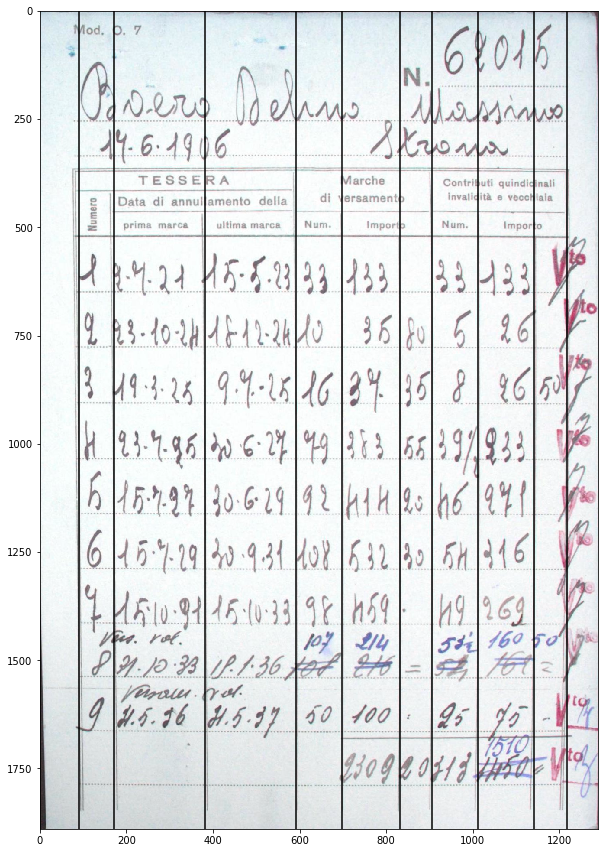

In [100]:
plt.figure(figsize=(10,20))
path = os.path.join(data_folder, img_fnms[101])
img = cv2.imread(path)
scanner = DocScanner()
img = scanner.scan(img)
peaks = find_peaks(spec, distance=30)[0]
plt.vlines(peaks, 0, img.shape[0])
plt.imshow(img)
plt.show()

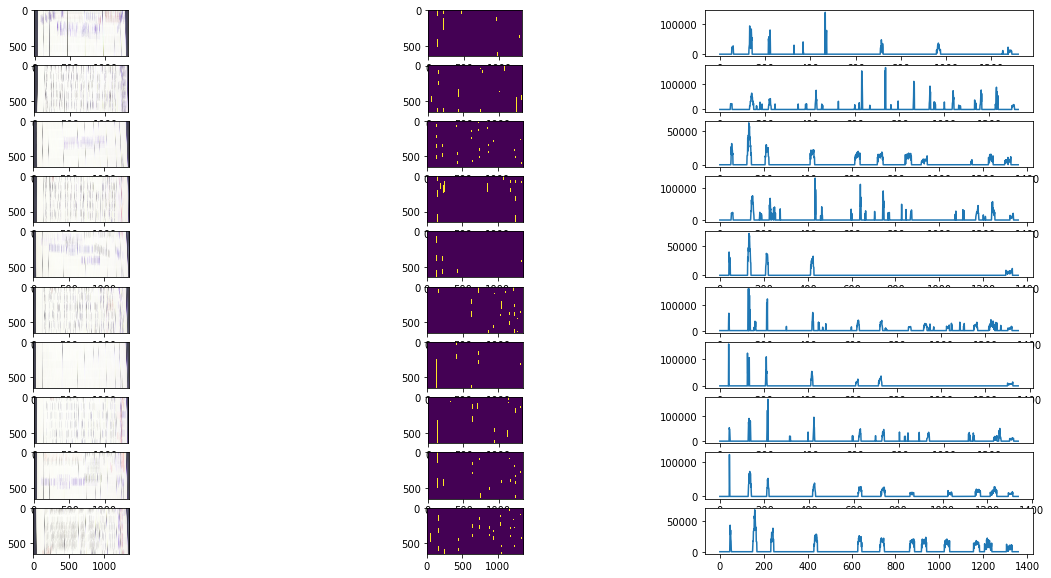

In [51]:
fig, axes = plt.subplots(10, 3, figsize=(20, 10))
for fn, ax in zip(img_fnms[100:110], axes):
    path = os.path.join(data_folder, fn)
    oimg = plt.imread(path).copy()
    img = oimg[600:1250].copy()
#     mask1 = img.sum(axis=2) < 700
#     mask2 = np.abs(img[:,:,0] - img[:,:,1]) < 100
#     mask3 = np.abs(img[:,:,0] - img[:,:,2]) < 100
#     mask = mask2 * mask3
#     img[mask] = 0
#     img[~mask] = 255
    
    img = cv2.blur(img, (1, 99))
    edges = cv2.Canny(img, 50, 200)
#     lines = cv2.HoughLinesP(edges,1,np.pi/180,40,minLineLength=30,maxLineGap=5000)
#     for x1,y1,x2,y2 in lines[0]:
#         cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)
    ax[0].imshow(img)
    ax[1].imshow(edges)
    ax[2].plot(edges.sum(axis=0))
plt.show()